# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></div><div class="lev1 toc-item"><a href="#Look-at-few-random-images" data-toc-modified-id="Look-at-few-random-images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Look at few random images</a></div><div class="lev1 toc-item"><a href="#Worst-10" data-toc-modified-id="Worst-10-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Worst 10</a></div><div class="lev2 toc-item"><a href="#Load-previously-trained-model" data-toc-modified-id="Load-previously-trained-model-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load previously trained model</a></div><div class="lev2 toc-item"><a href="#Generate-predictions" data-toc-modified-id="Generate-predictions-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate predictions</a></div><div class="lev2 toc-item"><a href="#Worst-10" data-toc-modified-id="Worst-10-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Worst 10</a></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from os import listdir
ids_list = [x.split('.')[0] for x in listdir('data/train')]

# Look at few random images

In [4]:
def plot_img_mask(img, mask, is_filepath = True):
    if is_filepath:
        img = cv2.imread(img)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.imshow(img_masked)
    plt.show()

In [5]:
import random

In [6]:
def plot_random_img():
    random_id = random.choice(ids_list)
    plot_img_mask('data/train/' + random_id + '.jpg', 'data/train_masks/' + random_id + '_mask.png')

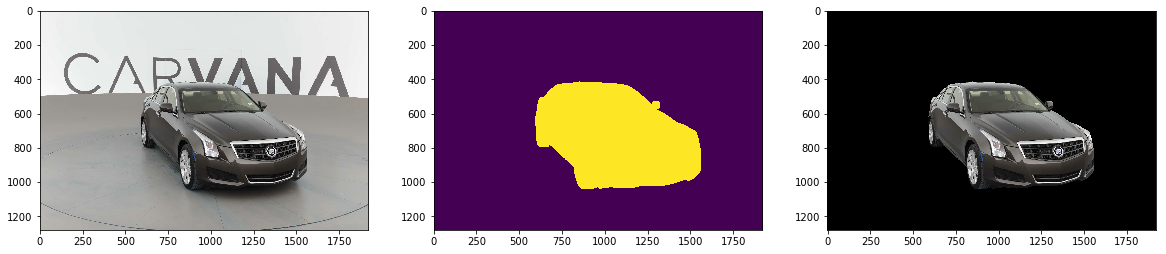

In [7]:
plot_random_img()

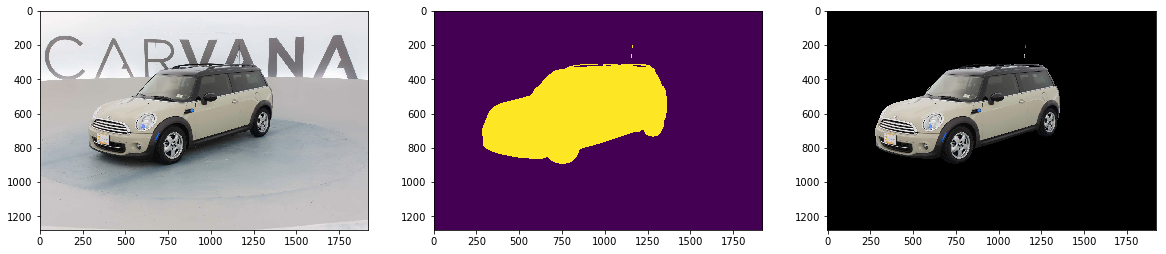

In [8]:
plot_random_img()

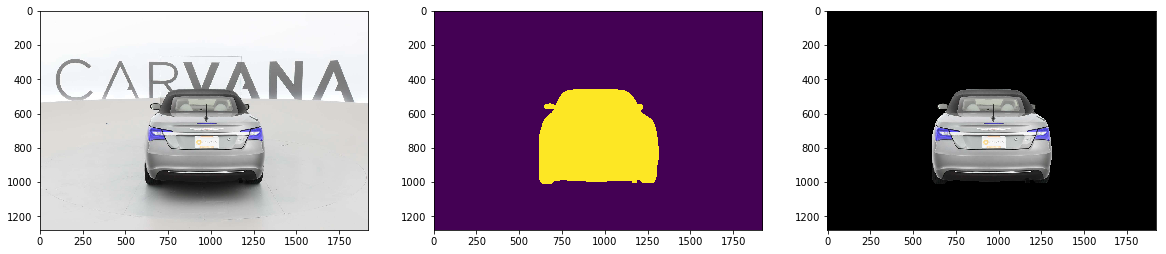

In [9]:
plot_random_img()

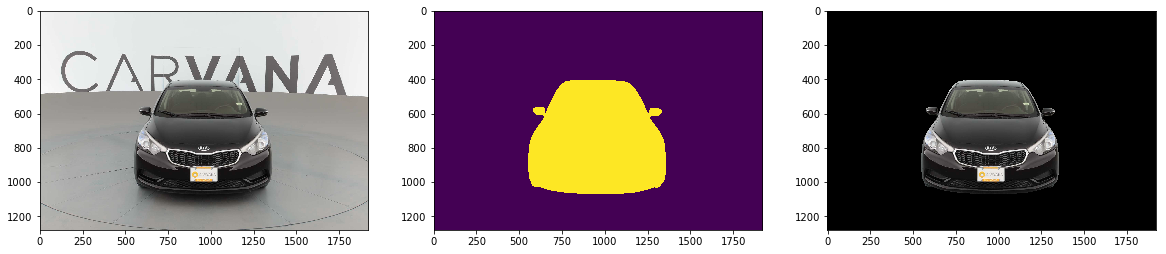

In [10]:
plot_random_img()

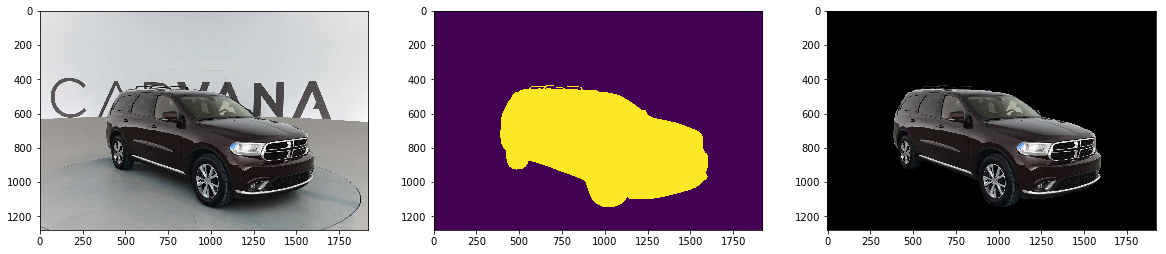

In [11]:
plot_random_img()

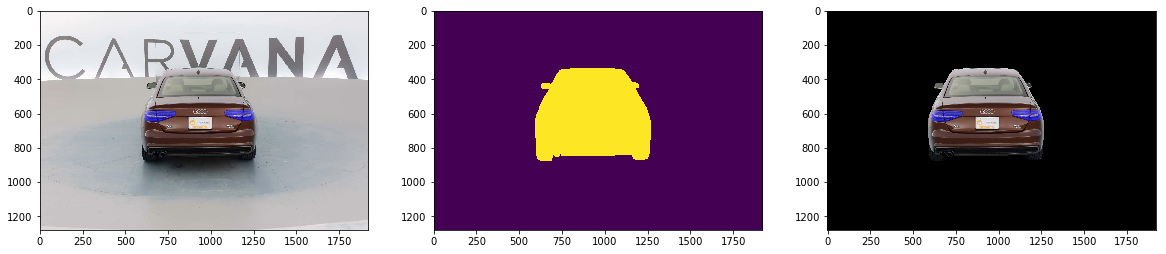

In [12]:
plot_random_img()

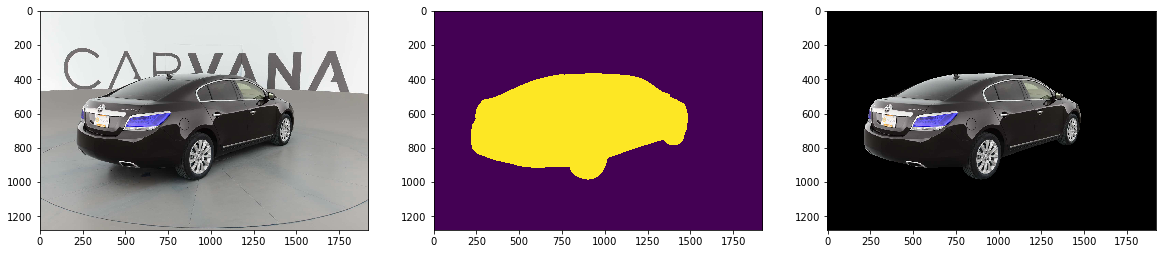

In [13]:
plot_random_img()

# Worst 10

## Load previously trained model

In [14]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

model = get_unet(input_shape=(512,512,3), initial_filters=16)
model.load_weights(filepath='weights/best_weights_512.hdf5')

## Generate predictions

In [15]:
import pickle

In [16]:
with open("data/all_imgs_resized_512.pkl", "rb") as f:
    all_imgs = pickle.load(f)

In [18]:
preds = model.predict(np.array(all_imgs, np.float32)/255, batch_size=16)
preds = np.squeeze(preds, axis=3)

## Worst 10

In [19]:
orig_width = 1918
orig_height= 1280

def dice_loss_numpy(y_true, y_pred):
    return 2*np.sum(np.multiply(y_true, y_pred))/(np.sum(y_pred) + np.sum(y_true))

In [20]:
dice_loss_vals=[]
for i in range(len(ids_list)):
    tmp = np.copy(preds[i,:,:])
    tmp = cv2.resize(tmp, (orig_width, orig_height))
    tmp = (tmp > 0.5).astype(int)
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(ids_list[i]), cv2.IMREAD_GRAYSCALE)/255
    dice_loss_vals.append(dice_loss_numpy(mask, tmp))

In [21]:
sorted_dice_loss_vals = list(sorted(zip(ids_list, dice_loss_vals, range(len(ids_list))), key=lambda x:x[1]))

In [35]:
def plt_ith_diff(i):
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(sorted_dice_loss_vals[i][0]), cv2.IMREAD_GRAYSCALE)/255
    tmp = np.copy(preds[sorted_dice_loss_vals[i][2],:,:])
    tmp = cv2.resize(tmp, (orig_width, orig_height))
    tmp = (tmp > 0.5).astype(int)
    
    print(dice_loss_numpy(mask, tmp))
    
    plt.figure(figsize=(15, 15))
    plt.imshow(np.subtract(tmp, mask));

0.989640461775


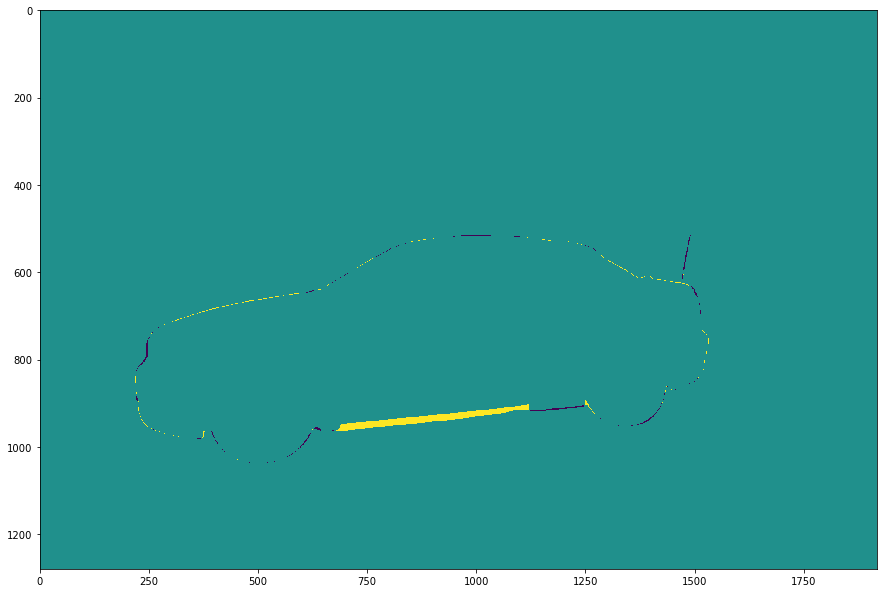

In [36]:
plt_ith_diff(0)

0.99004630646


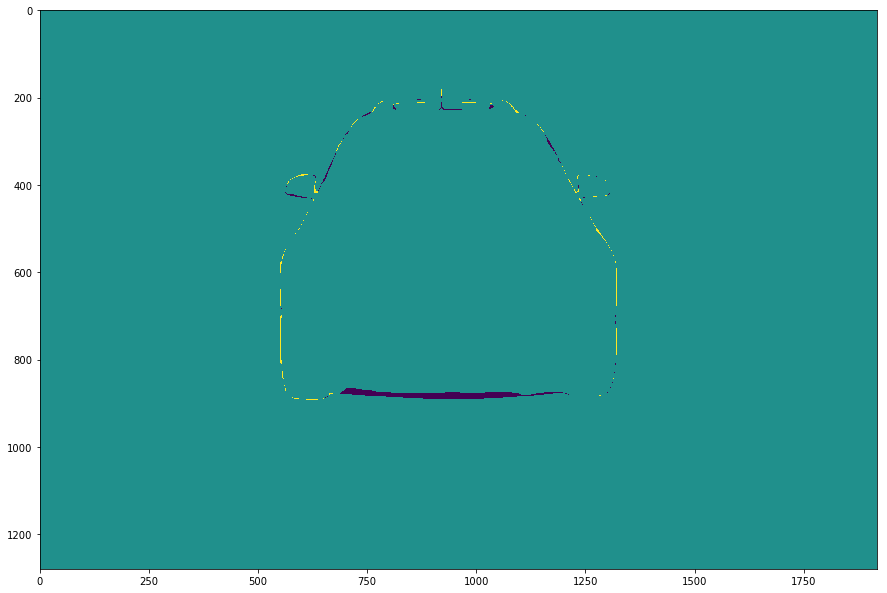

In [37]:
plt_ith_diff(1)

0.990159778941


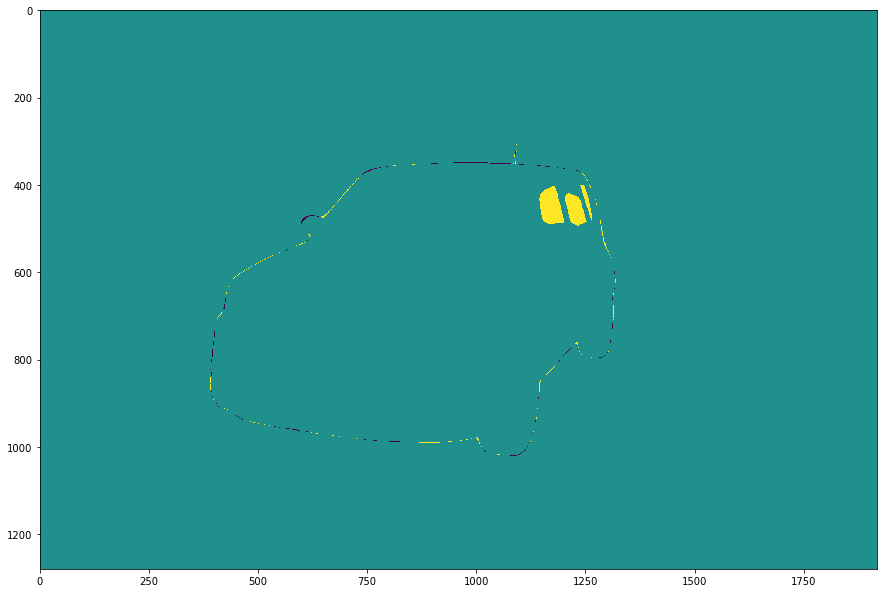

In [38]:
plt_ith_diff(2)

0.990269979151


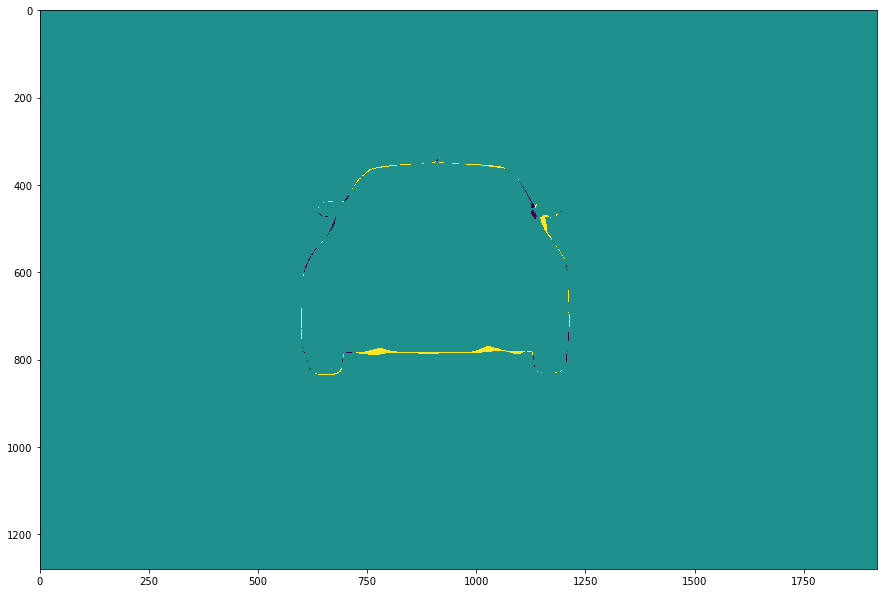

In [39]:
plt_ith_diff(3)

0.991240205394


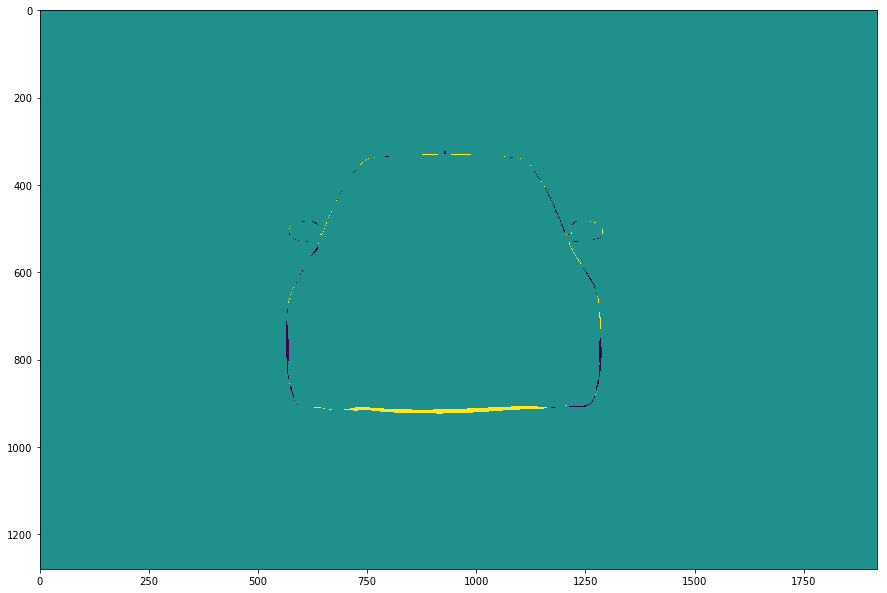

In [40]:
plt_ith_diff(4)

0.991323366441


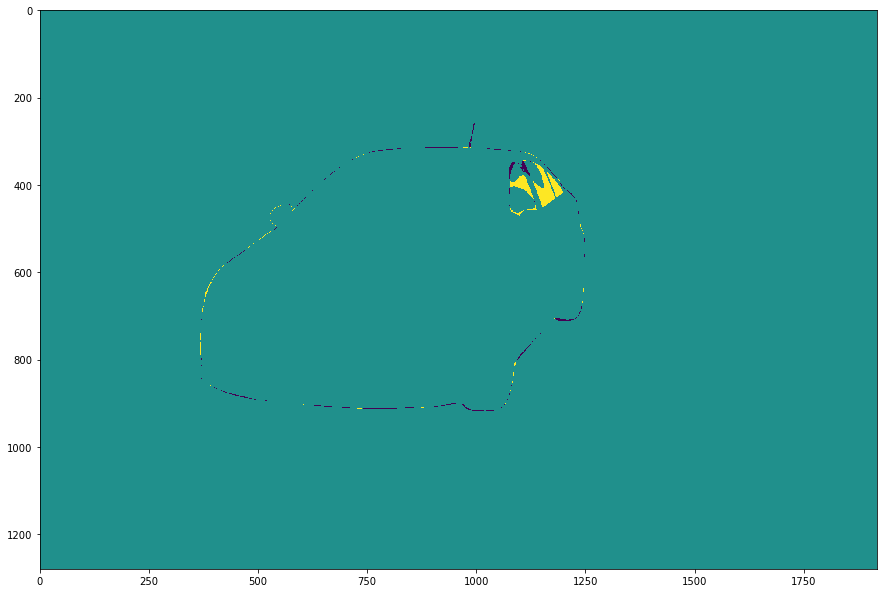

In [41]:
plt_ith_diff(5)

0.991332487932


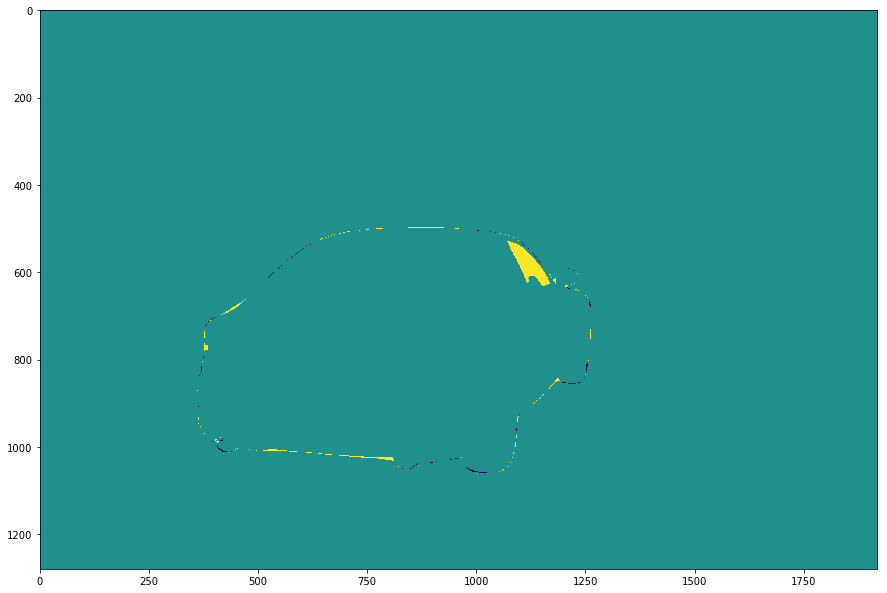

In [42]:
plt_ith_diff(6)

0.991538817046


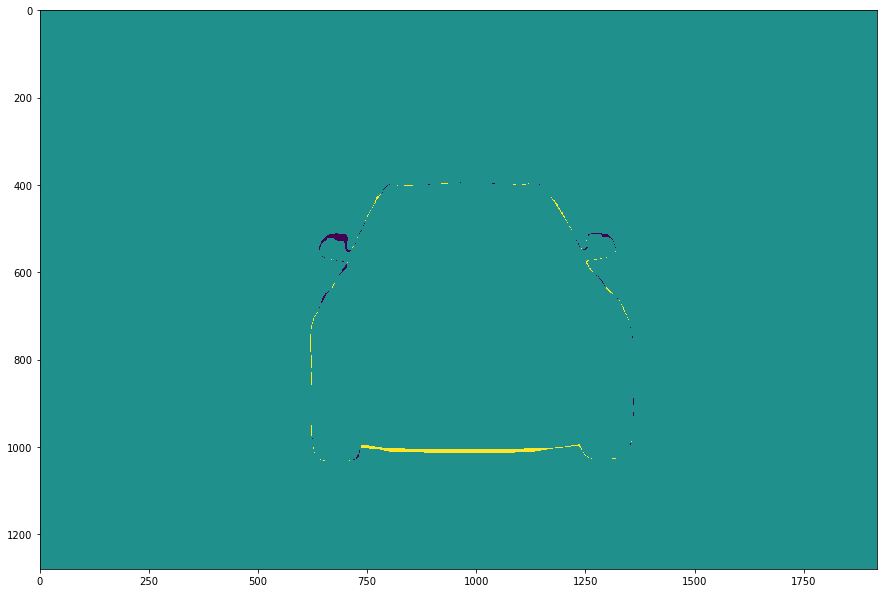

In [43]:
plt_ith_diff(7)

0.991633378693


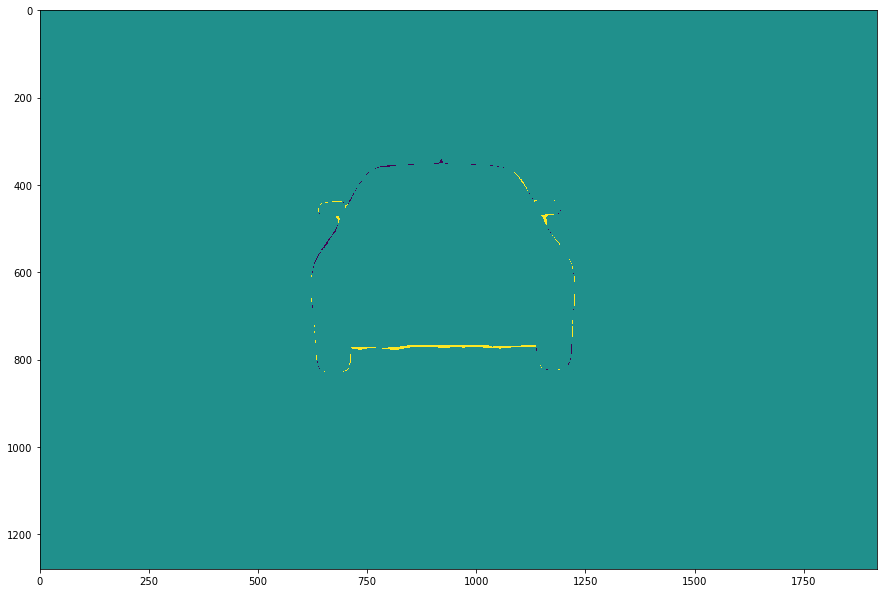

In [44]:
plt_ith_diff(8)

0.991675434956


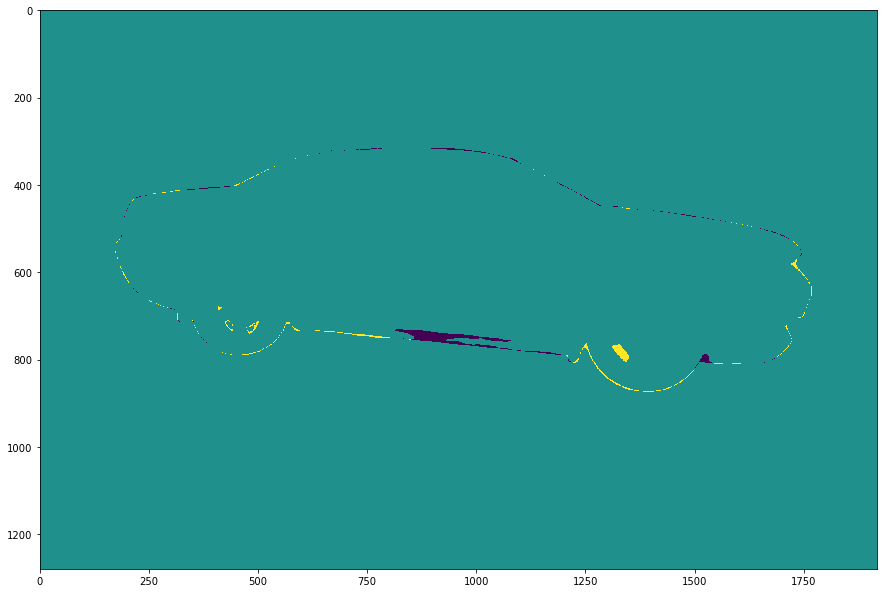

In [45]:
plt_ith_diff(9)